# Neural networks approach for sentiment analysis

This notebook presents neural networks approach for predicting reviews sentiment. The data was analized and prepared for modelling in `Data_analysis.ipynb` notebook. Three kinds of layers were used:
 - Embedding (using pretrained _Glove_ word embeddings)
 - Bidirectional LSTM layer
 - Dense layer

__Note:__ Because almost 93% of the reviews are positive some imbalanced classification problem steps were undertaken.

Two cases were considered:
 1. Binary classification - only positive and negative reviews were taken into account. Networks were built using two approaches
 - 1.1. Fitting model without any operations with regard to imlabance
 - 1.2. Usage of sample weight parameters in model fitting
 
 2. Multiclass classification - all kinds of reviews were taken into account (positive, negative, neutral).  Networks were built using two approaches
 - 2.1. Fitting model without any operations with regard to imlabance
 - 2.2. Usage of sample weight parameters in model fitting
 
__Note:__ Many different layer settings were tried out and only small part of these models is shown in this notebook

__Loading libraries__

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,
classification_report, plot_roc_curve, roc_curve, classification_report

import os
import matplotlib.pyplot as plt
from datetime import date

In [2]:
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras import preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.models import load_model

In [3]:
pd.set_option("max_colwidth", 1000)

__Loading the dataset__

In [4]:
data = pd.read_csv('Data_NN.csv', index_col='Unnamed: 0')

__Loading the pretrained word embeddings (_glove_ embedding)__

In [5]:
# available dimensions: 50, 100, 200, 300
embedding_dim = 300
# how many top words will be considered
max_words = 10000

# loading pretrained word embeddings
dir_ = 'glove'
embeddings_index = {}
f = open(os.path.join(dir_, f'glove.6B.{embedding_dim}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# 1. Binary classification

__Preparing data for keras__

In [6]:
data_preprocessed_binary = data[data.rating != 3]

In [7]:
# changing pandas reviews to list 
X = data_preprocessed_binary.review.values.tolist()
y = data_preprocessed_binary.loc[:, 'rating'].astype('float32').values

In [8]:
# splitting the dataset into test and train set
y = to_categorical(y, num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=100)

In [9]:
# top 10000 words are considered
tokenizer = Tokenizer(
    num_words=max_words, lower=False, filters="")
tokenizer.fit_on_texts(X)

# changing reviews to sequences of integers
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# max length of a review; different lengths were tested as well
maxlen=200
x_train = preprocessing.sequence.pad_sequences(
    sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(
    sequences_test, maxlen=maxlen)

# what index has a given word
word_index = tokenizer.word_index

In [10]:
# building embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [11]:
def word_with_index(position):
    """
    the function shows a word at a given position (number)
    in the tokenizer
    """
    key_list = list(word_index.keys())
    val_list = list(word_index.values())
    position = val_list.index(position)
    print(key_list[position])

In [12]:
for i in [1, 10, 50, 100, 1000, 1500, 4000]:
    print(f'word with index {i}:', end=" ")
    word_with_index(i)

word with index 1: the
word with index 10: this
word with index 50: new
word with index 100: even
word with index 1000: cutting
word with index 1500: teeth
word with index 4000: store,


In [50]:
# a variable for training/loading models
# if it is True the pretrained models are loaded
# otherwise the models are loaded
load = True

__Model training__

In [51]:
# building neural networks
if not load:
    # model without sample weights
    early_stopping = EarlyStopping(
        patience=4, monitor='val_loss', restore_best_weights=True)

    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    model.add(Dense(128, 'tanh'))
    model.add(Dense(32, 'tanh'))
    model.add(Dense(2, 'softmax'))

    # using the pretrained embeddings
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

    model.compile(
        loss='binary_crossentropy', optimizer='adam', metrics=[
            'binary_accuracy'])
    model.summary()
    model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=32, 
        validation_split=0.2, 
        callbacks=[early_stopping])

#-------------------------------------model with sample weights -----------------------------------------------------------
 
    sample_weights = np.where(y_train[:, 1] == 1., 1., 20.) 
    modelSW = Sequential()
    
    modelSW.add(
        Embedding(
            max_words, embedding_dim, input_length=maxlen))
    
    modelSW.add(
        Bidirectional(
            LSTM(128, return_sequences=False)))
    
    modelSW.add(Dense(128, 'tanh'))
    
    modelSW.add(Dense(32, 'tanh'))
    
    modelSW.add(Dense(2, 'softmax'))

    # using the pretrained embeddings
    modelSW.layers[0].set_weights([embedding_matrix])
    modelSW.layers[0].trainable = False

    modelSW.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['binary_accuracy'])
    
    modelSW.summary()
    
    modelSW.fit(x_train,
                y_train,
                epochs=100,
                batch_size=32, 
                validation_split=0.2, 
                callbacks=[early_stopping],
                sample_weight=sample_weights)

#     modelB_128_128_300 = model
#     modelB_128_128_300SW = modelSW
    
else:
    # word embeddings dimension 300 with sample weights
    modelB_64_64_300 = load_model('models/modelB_64_64_300.h5')
    
    # word embeddings dimension 300 without sample weights    
    modelB_64_64_300SW = load_model('models/modelB_64_64_300SW.h5')
    
    # word embeddings dimension 300 without sample weights with more neurons
    modelB_128_128_300 = load_model('models/modelB_128_128_300.h5')
    
    # word embeddings dimension 100 without sample weights    
    modelB_128_128_300SW = load_model('models/modelB_128_128_300SW.h5')

In [22]:
def ROC_NN(model, x_test, y_test):
    """
    The function for calculating ROC parameters
    """
    y_pred_proba = model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test.argmax(1),y_pred_proba[:,1])
    return fpr, tpr, thresholds

## Binary models evaluation
__ROC for built models__

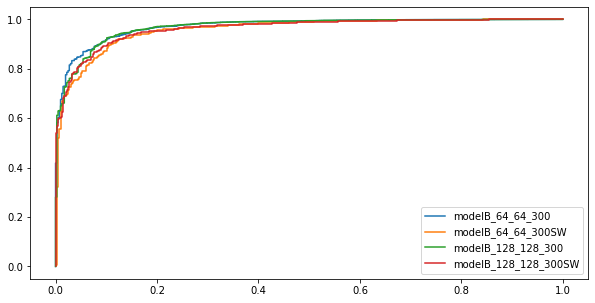

In [23]:
models = [(modelB_64_64_300, 'modelB_64_64_300'), 
          (modelB_64_64_300SW, 'modelB_64_64_300SW'),
          (modelB_128_128_300, 'modelB_128_128_300'),
          (modelB_128_128_300SW, 'modelB_128_128_300SW')]

fig, ax = plt.subplots(figsize=(10,5))
leg = []
for m in models:
    fpr, tpr, _ = ROC_NN(m[0], x_test, y_test)
    ax.plot(fpr, tpr)
    leg.append(m[1])
    
ax.legend(leg)

In [26]:
final_model_binary = modelB_64_64_300

__Adjusting probability threshold__

In [27]:
fpr, tpr, thr = ROC_NN(final_model_binary, x_test, y_test)

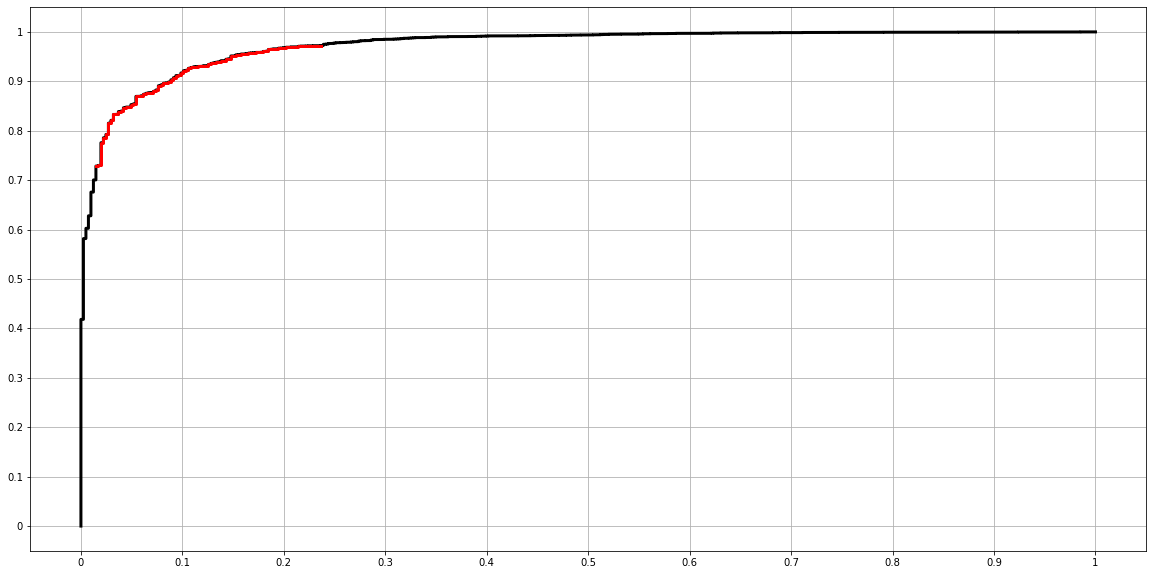

In [31]:
s, e = 1400, 1590
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(fpr, tpr, color='black', lw=3)
ax.plot(fpr[s:e], tpr[s:e], color='red', lw=3)
ax.grid(which='both')
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=[
    0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks(ticks=np.arange(0,1.1,0.1), labels=[
    0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [34]:
# array for selecting optimal probability threshold
# the first and the last value of the red line in the chart above
# np.hstack([tpr.reshape(-1, 1),fpr.reshape(-1, 1), thr.reshape(-1, 1)])[s:e]

In [33]:
threshold = 0.95
y_pred_proba_pos = final_model_binary.predict(x_test)[:,1]
y_pred = np.where(y_pred_proba_pos > threshold, 1, 0)
print(confusion_matrix(y_test.argmax(1), y_pred))
print(classification_report(y_test.argmax(1), y_pred))
cm = confusion_matrix(y_test.argmax(1), y_pred)

print(f'number of reviews that are positive and are predicted as positive: {cm[1][1]}')
print(f'number of reviews that are negative and are predicted as negative: {cm[0][0]}')
print(f'number of reviews that are negative and are predicted as positive: {cm[0][1]}')
print(f'number of reviews that are positive and are predicted as negative: {cm[1][0]}')

[[ 365   41]
 [ 706 7824]]
              precision    recall  f1-score   support

           0       0.34      0.90      0.49       406
           1       0.99      0.92      0.95      8530

    accuracy                           0.92      8936
   macro avg       0.67      0.91      0.72      8936
weighted avg       0.97      0.92      0.93      8936

number of reviews that are positive and are predicted as positive: 7824
number of reviews that are negative and are predicted as negative: 365
number of reviews that are negative and are predicted as positive: 41
number of reviews that are positive and are predicted as negative: 706


# 2. Multiclass classification

In [35]:
def model_summary(model, X_test, y_test):
    """
    Function that prints classification report and confusion matrix for a given model
    """
    y_pred = model.predict(X_test).argmax(1)
    print('\nconfusion matrix\n', confusion_matrix(y_test.argmax(1), y_pred))

    print('\nclassification report\n',classification_report(y_test.argmax(1), y_pred))

__Adjusting y values for keras__

In [36]:
data.rating.replace({3:1, 1:2, 0:0}, inplace=True)

__Preparing data for keras__

In [37]:
X = data.review.values.tolist()
y = data.loc[:, 'rating'].astype('float')
y = to_categorical(y, num_classes=3)
X_train_MC, X_test_MC, y_train_MC, y_test_MC = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=100)

In [38]:
# top 10000 words are considered
tokenizer_MC = Tokenizer(num_words=10000)
tokenizer_MC.fit_on_texts(X_train_MC)
sequences_train_MC = tokenizer_MC.texts_to_sequences(X_train_MC)
sequences_test_MC = tokenizer_MC.texts_to_sequences(X_test_MC)

maxlen=200
x_train_MC = preprocessing.sequence.pad_sequences(
    sequences_train_MC, maxlen=maxlen)

x_test_MC = preprocessing.sequence.pad_sequences(
    sequences_test_MC, maxlen=maxlen)

word_index_MC = tokenizer_MC.word_index

In [39]:
embedding_dim = 300
max_words=10000

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index_MC.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [48]:
load = True

In [49]:
if not load:
    early_stopping = EarlyStopping(
        patience=4, monitor='val_loss', restore_best_weights=True)
    
    # model without sample weights
    model = Sequential()
    model.add(
        Embedding(max_words, embedding_dim, input_length=maxlen))
    
    model.add(
        Bidirectional(LSTM(128, return_sequences=False)))
    
    model.add(Dense(128, 'tanh'))
    
    model.add(Dense(32, 'tanh'))
    
    model.add(Dense(3, 'softmax'))

    #using the pretrained embeddings
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['categorical_accuracy'])
    
    model.summary()
    model.fit(
        x_train_MC,
        y_train_MC,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping])
    
    
#     model.save(f'multiclass{str(date.today())}.h5')

#-------------------------------------------model with sample weights------------------------------------------------------  
    sample_weights = np.where(y_train_MC[:,2] == 1., 1., 20.) 

    modelSW = Sequential()
    modelSW.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    modelSW.add(Bidirectional(LSTM(128, return_sequences=False)))
    modelSW.add(Dense(128, 'tanh'))
    modelSW.add(Dense(32, 'tanh'))
    modelSW.add(Dense(3, 'softmax'))

    #using the pretrained embeddings
    modelSW.layers[0].set_weights([embedding_matrix])
    modelSW.layers[0].trainable = False

    modelSW.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['categorical_accuracy'])
    
    modelSW.summary()
    modelSW.fit(
        x_train_MC,
        y_train_MC,
        epochs=100,
        batch_size=32, 
        validation_split=0.2, 
        callbacks=[early_stopping],
        sample_weight=sample_weights)
    
#     modelMC_128_128_300 = model
#     modelMC_128_128_300SW = modelSW

else:
    # word embeddings dimension 300 with sample weights
    modelMC_64_64_300 = load_model('models/modelMC_64_64_300.h5')

    # word embeddings dimension 300 without sample weights    
    modelMC_64_64_300SW = load_model('models/modelMC_64_64_300SW.h5')

    # word embeddings dimension 300 without sample weights with more neurons
    modelMC_128_128_300 = load_model('models/modelMC_128_128_300.h5')

    # word embeddings dimension 100 without sample weights    
    modelMC_128_128_300SW = load_model('models/modelMC_128_128_300SW.h5')

## Multiclass models evaluation

In [46]:
modelsMC = [(modelMC_64_64_300, 'modelMC_64_64_300'), 
            (modelMC_64_64_300SW, 'modelMC_64_64_300SW'),
            (modelMC_128_128_300, 'modelMC_128_128_300'),
            (modelMC_128_128_300SW, 'modelMC_128_128_300SW')]

for m in modelsMC:
    print(f'model {m[1]}')
    model_summary(m[0], x_test_MC, y_test_MC)
    print()

model MC_300

confusion matrix
 [[ 269    7  130]
 [  68   15  205]
 [  87   16 8427]]

classification report
               precision    recall  f1-score   support

           0       0.63      0.66      0.65       406
           1       0.39      0.05      0.09       288
           2       0.96      0.99      0.97      8530

    accuracy                           0.94      9224
   macro avg       0.66      0.57      0.57      9224
weighted avg       0.93      0.94      0.93      9224


model MC_300_2

confusion matrix
 [[ 352   38   16]
 [ 115  110   63]
 [ 516  679 7335]]

classification report
               precision    recall  f1-score   support

           0       0.36      0.87      0.51       406
           1       0.13      0.38      0.20       288
           2       0.99      0.86      0.92      8530

    accuracy                           0.85      9224
   macro avg       0.49      0.70      0.54      9224
weighted avg       0.93      0.85      0.88      9224


model MC_300

### Conclusion: these models perform rather poorly and they weren't analized in details 